In [91]:
import os
# 現在の作業ディレクトリを表示
print(os.getcwd())

/Users/ryujisasaki


In [93]:
import pandas as pd
import numpy as np

In [123]:
# Excelファイルからデータを読み込みます
data = pd.read_excel('/Users/ryujisasaki/anaconda3/jps2025_catb/tri_honban_analysis_final_data.xlsx')

In [127]:
data.head()

,year,month,wd,time_z,id,male,bd,age_month,ambu,dx,...,spo,hr,bt,crt,sbp,tri,fX,fY,iConf,iLvl
0,2018,4,2,3,2942160,2,2013/03/28,60,0,急性胃腸炎,...,98,3,37.9,1,100,3,139.57867,35.63186,5.0,7.0
1,2018,4,2,3,2902141,1,2017/07/18,8,0,急性上気道炎,...,99,4,38.4,1,90,4,139.64117,35.66720,5.0,7.0
2,2018,4,2,3,765457,1,2006/08/02,140,0,アナフィラキシー,...,98,4,36.5,1,100,3,139.65041,35.62035,5.0,7.0
3,2018,4,2,3,2942178,2,2018/01/23,2,0,気管支炎,...,98,4,37.0,1,90,4,139.58154,35.62645,5.0,7.0
4,2018,4,2,3,2488701,2,2015/12/04,28,0,気管支喘息発作,...,97,4,36.7,1,90,4,139.51411,35.63776,5.0,7.0


In [129]:
# 前処理: 指定された変数を除外します
excluded_columns = [ 'bd', 'dx', 'id', 'picu', 'transf','or', 'fX', 'fY', 'iConf', 'iLvl']
data_cat = data.drop(columns=excluded_columns)




In [131]:
# 各列の欠損値の数を表示
print(data_cat.isnull().sum())


year                   0
month                  0
wd                     0
time_z                 0
male                   0
age_month              0
ambu                   0
cov                    0
adm                    0
syo_sai2               0
ref                    0
hot               132862
pat                    0
ph_ba             127615
ph_chd            131921
ph_chromo         132331
ph_zaitaku        129558
ph_epi            131764
ph_transp_neop    131766
cc_cat                23
rr                     0
spo                    0
hr                     0
bt                     0
crt                    0
sbp                    0
tri                    0
dtype: int64


In [133]:
# NAを0に変換する変数
na_to_zero_cols = ['ph_ba', 'ph_chd', 'ph_chromo', 'ph_zaitaku', 'ph_epi', 'ph_transp_neop', 'hot']
data_cat[na_to_zero_cols] = data_cat[na_to_zero_cols].fillna(0)

# カテゴリ変数を適切にカテゴリ型に変換する
categorical_cols = ['year', 'month', 'wd', 'time_z', 'male', 'ambu', 'cov', 'syo_sai2', 'ref', 'hot', 'pat', 'tri', 'rr', 'cc_cat']
for col in categorical_cols:
    data_cat[col] = data_cat[col].astype(str)  # CatBoostのエラーを防ぐため、カテゴリ変数を文字列に変換

In [105]:
# 前処理が完了したことを確認
print(data_cat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133326 entries, 0 to 133325
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            133326 non-null  object 
 1   month           133326 non-null  object 
 2   wd              133326 non-null  object 
 3   time_z          133326 non-null  object 
 4   male            133326 non-null  object 
 5   age_month       133326 non-null  int64  
 6   ambu            133326 non-null  object 
 7   cov             133326 non-null  object 
 8   adm             133326 non-null  int64  
 9   syo_sai2        133326 non-null  object 
 10  ref             133326 non-null  object 
 11  hot             133326 non-null  object 
 12  pat             133326 non-null  object 
 13  ph_ba           133326 non-null  float64
 14  ph_chd          133326 non-null  float64
 15  ph_chromo       133326 non-null  float64
 16  ph_zaitaku      133326 non-null  float64
 17  ph_epi    

In [107]:
from catboost import CatBoostClassifier


In [135]:
print(data_cat.columns)


Index(['year', 'month', 'wd', 'time_z', 'male', 'age_month', 'ambu', 'cov',
       'adm', 'syo_sai2', 'ref', 'hot', 'pat', 'ph_ba', 'ph_chd', 'ph_chromo',
       'ph_zaitaku', 'ph_epi', 'ph_transp_neop', 'cc_cat', 'rr', 'spo', 'hr',
       'bt', 'crt', 'sbp', 'tri'],
      dtype='object')


In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# バイタルサインの列を指定
vital_signs = ['hr', 'rr', 'bt', 'sbp', 'crt', 'spo']

# モデル用の特徴量 (トリアージレベル、その他の因子を含む)
tri = 'tri'
other_variables = [ 'year',  'month',  'wd',  'time_z', 'male', 'age_month', 'cov', 'ambu',
                  'syo_sai2', 'ref', 'hot', 'pat', 'ph_ba', 'ph_chd', 'ph_chromo',
       'ph_zaitaku', 'ph_epi', 'ph_transp_neop', 'cc_cat' ]  # 他の予測因子の例

# 1. バイタルサインを含めたモデル
X_with_vs = data[vital_signs + [tri] + other_variables]

# 2. バイタルサインを除いたモデル
X_without_vs = data[[tri] + other_variables]

# ターゲット変数
y = data['adm']  # 入院予測ターゲット


In [139]:
# バイタルサインの列を数値に変換
for col in vital_signs:
    # 数値に変換できない値を NaN に置き換える
    data[col] = pd.to_numeric(data[col], errors='coerce')

# NaN を含む行を削除
data = data.dropna(subset=vital_signs)

# ここで、数値に変換できない値が含まれていた行が削除されます。


In [121]:
print(data_cat.columns)


Index(['year', 'month', 'wd', 'time_z', 'male', 'age_month', 'ambu', 'cov',
       'adm', 'syo_sai2', 'ref', 'hot', 'pat', 'ph_ba', 'ph_chd', 'ph_chromo',
       'ph_zaitaku', 'ph_epi', 'ph_transp_neop', 'cc_cat', 'rr', 'spo', 'hr',
       'bt', 'crt', 'sbp', 'tri'],
      dtype='object')


In [141]:
# データを一度にトレーニングとテストに分割
X_train_idx, X_test_idx, y_train, y_test = train_test_split(X_with_vs.index, y, test_size=0.2, random_state=42)

# インデックスを使って、X_with_vsとX_without_vsを分割
X_train_with_vs = X_with_vs.loc[X_train_idx]
X_test_with_vs = X_with_vs.loc[X_test_idx]

X_train_without_vs = X_without_vs.loc[X_train_idx]
X_test_without_vs = X_without_vs.loc[X_test_idx]

# モデルの定義と訓練を再実行
model_with_vs = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=100)
model_without_vs = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=100)

model_with_vs.fit(X_train_with_vs, y_train)
model_without_vs.fit(X_train_without_vs, y_train)


0:	learn: 0.5720339	total: 70.3ms	remaining: 35.1s
100:	learn: 0.2224960	total: 871ms	remaining: 3.44s
200:	learn: 0.2139686	total: 1.67s	remaining: 2.48s
300:	learn: 0.2080097	total: 2.45s	remaining: 1.62s
400:	learn: 0.2034829	total: 3.25s	remaining: 802ms
499:	learn: 0.1996020	total: 4.03s	remaining: 0us
0:	learn: 0.5670438	total: 7.71ms	remaining: 3.85s
100:	learn: 0.2259460	total: 794ms	remaining: 3.14s
200:	learn: 0.2197315	total: 1.57s	remaining: 2.34s
300:	learn: 0.2154618	total: 2.36s	remaining: 1.56s
400:	learn: 0.2121492	total: 3.14s	remaining: 776ms
499:	learn: 0.2091913	total: 3.92s	remaining: 0us


In [143]:
# テストデータで予測 (バイタルサインを含む)
y_pred_with_vs = model_with_vs.predict(X_test_with_vs)
y_pred_proba_with_vs = model_with_vs.predict_proba(X_test_with_vs)[:, 1]

# テストデータで予測 (バイタルサインを除く)
y_pred_without_vs = model_without_vs.predict(X_test_without_vs)
y_pred_proba_without_vs = model_without_vs.predict_proba(X_test_without_vs)[:, 1]


In [145]:

# AUCの計算
auc_with_vs = roc_auc_score(y_test, y_pred_proba_with_vs)
auc_without_vs = roc_auc_score(y_test, y_pred_proba_without_vs)

# F1スコアの計算
f1_with_vs = f1_score(y_test, y_pred_with_vs)
f1_without_vs = f1_score(y_test, y_pred_without_vs)

# 精度の計算
accuracy_with_vs = accuracy_score(y_test, y_pred_with_vs)
accuracy_without_vs = accuracy_score(y_test, y_pred_without_vs)

# 結果の出力
print(f"Model with Vital Signs - AUC: {auc_with_vs}, F1: {f1_with_vs}, Accuracy: {accuracy_with_vs}")
print(f"Model without Vital Signs - AUC: {auc_without_vs}, F1: {f1_without_vs}, Accuracy: {accuracy_without_vs}")

Model with Vital Signs - AUC: 0.88582280323179, F1: 0.43927776403660646, Accuracy: 0.9149853746343659
Model without Vital Signs - AUC: 0.8803490139377804, F1: 0.40867810292633705, Accuracy: 0.9120978024450611


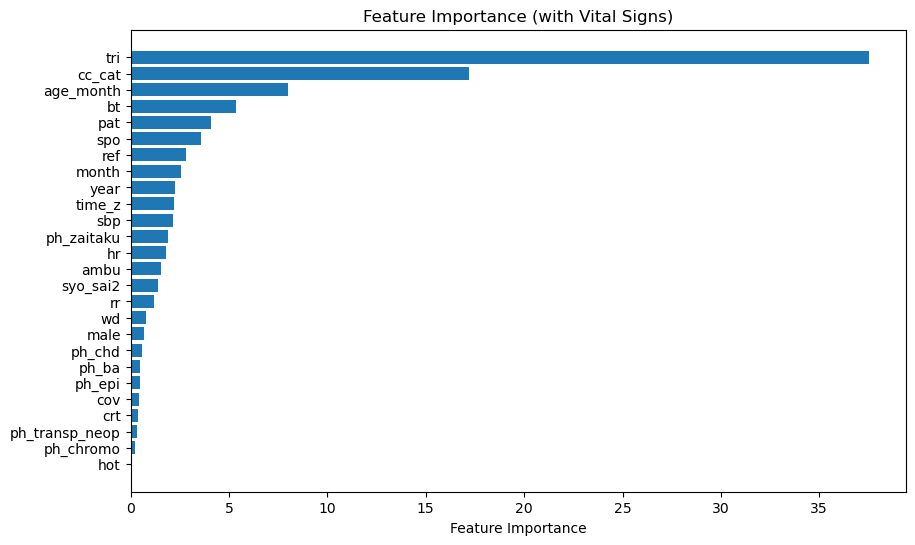

In [147]:
import matplotlib.pyplot as plt
import numpy as np

# バイタルサインを含めたモデルの特徴量の重要度を取得
feature_importances = model_with_vs.get_feature_importance()
feature_names = X_train_with_vs.columns

# 特徴量を重要な順にソート
indices = np.argsort(feature_importances)[::-1]

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
plt.title('Feature Importance (with Vital Signs)')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()  # 重要度が高い順に表示
plt.xlabel('Feature Importance')
plt.show()


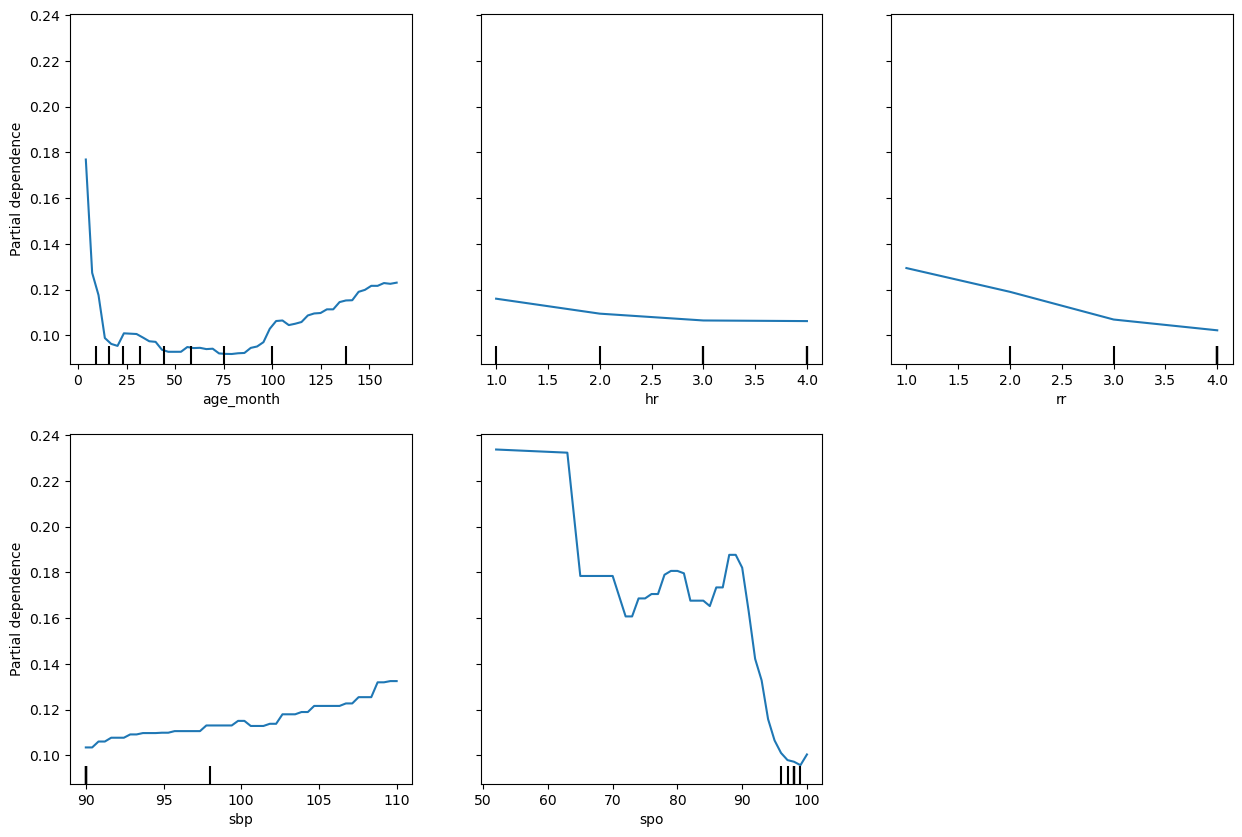

In [178]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 連続変数を指定 (例として、age_month, hr, rr, sbp, spo)
continuous_features = ['age_month', 'hr', 'rr', 'sbp', 'spo']  # 連続変数の例

# プロットサイズを設定（横長で大きめの図）
fig, ax = plt.subplots(figsize=(15, 10))  # figsizeを大きくして調整

# PDPのプロット (連続変数)
PartialDependenceDisplay.from_estimator(
    model_with_vs, X_test_with_vs, continuous_features, grid_resolution=50, ax=ax
)

# プロットを表示
plt.show()


In [151]:
!pip install pdpbox


In [158]:
!pip show pdpbox


Name: PDPbox
Version: 0.3.0
Summary: Python partial dependence plot toolbox
Home-page: https://github.com/SauceCat/PDPbox
Author: sosuneko
Author-email: jiangchun.lee@gmail.com
License: MIT
Location: /opt/anaconda3/lib/python3.12/site-packages
Requires: joblib, matplotlib, numpy, numpydoc, pandas, plotly, pqdm, psutil, pytest, scikit-learn, setuptools, sphinx, sphinx-rtd-theme, tqdm, xgboost
Required-by: 


In [164]:
import sklearn
print(sklearn.__version__)


1.5.1


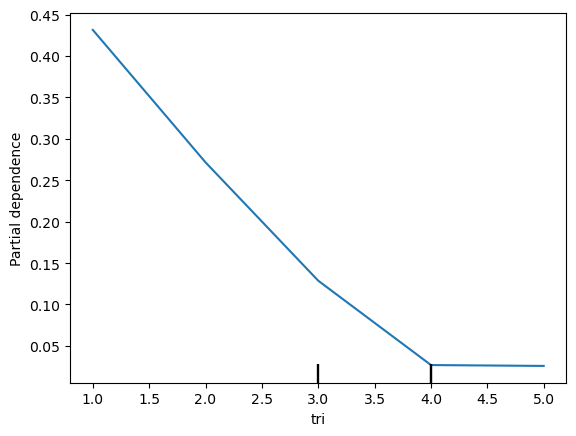

In [166]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 重要な特徴量を取得
important_feature = feature_names[indices[0]]  # 最も重要な特徴量

# PDPのプロット
PartialDependenceDisplay.from_estimator(model_with_vs, X_test_with_vs, [important_feature], grid_resolution=50)

# プロットを表示
plt.show()


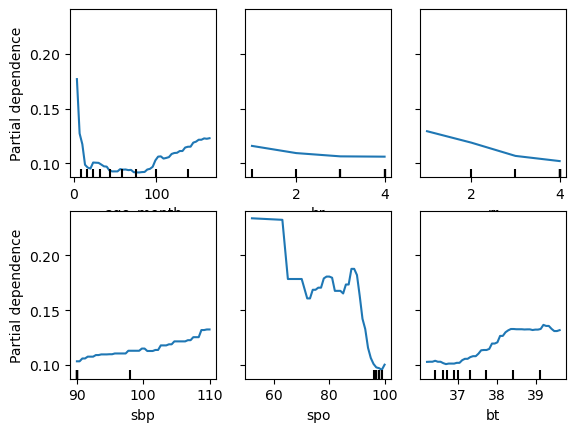

In [176]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 連続変数を指定
continuous_features = ['age_month', 'hr', 'rr', 'sbp', 'spo','bt' ]  # 連続変数の例

# PDPのプロット (連続変数)
PartialDependenceDisplay.from_estimator(model_with_vs, X_test_with_vs, continuous_features, grid_resolution=50)

# プロットを表示
plt.show()



In [31]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 連続変数を指定
continuous_features = ['age_month']  # 連続変数の例

# PDPのプロット (連続変数)
PartialDependenceDisplay.from_estimator(model_with_vs, X_test_with_vs, continuous_features, grid_resolution=50)

# プロットを表示
plt.show()

# プロットサイズを設定（横長で大きめの図）
fig, ax = plt.subplots(figsize=(15, 10))  # figsizeを大きくして調整

# PDPのプロット (連続変数)
PartialDependenceDisplay.from_estimator(
    model_with_vs, X_test_with_vs, continuous_features, grid_resolution=50, ax=ax
)

# 図をファイルに保存
plt.savefig("pdp_plot_age.png")  # "pdp_plot.png" は保存するファイル名

# プロットを表示
plt.show()


NameError: name 'X_test_with_vs' is not defined

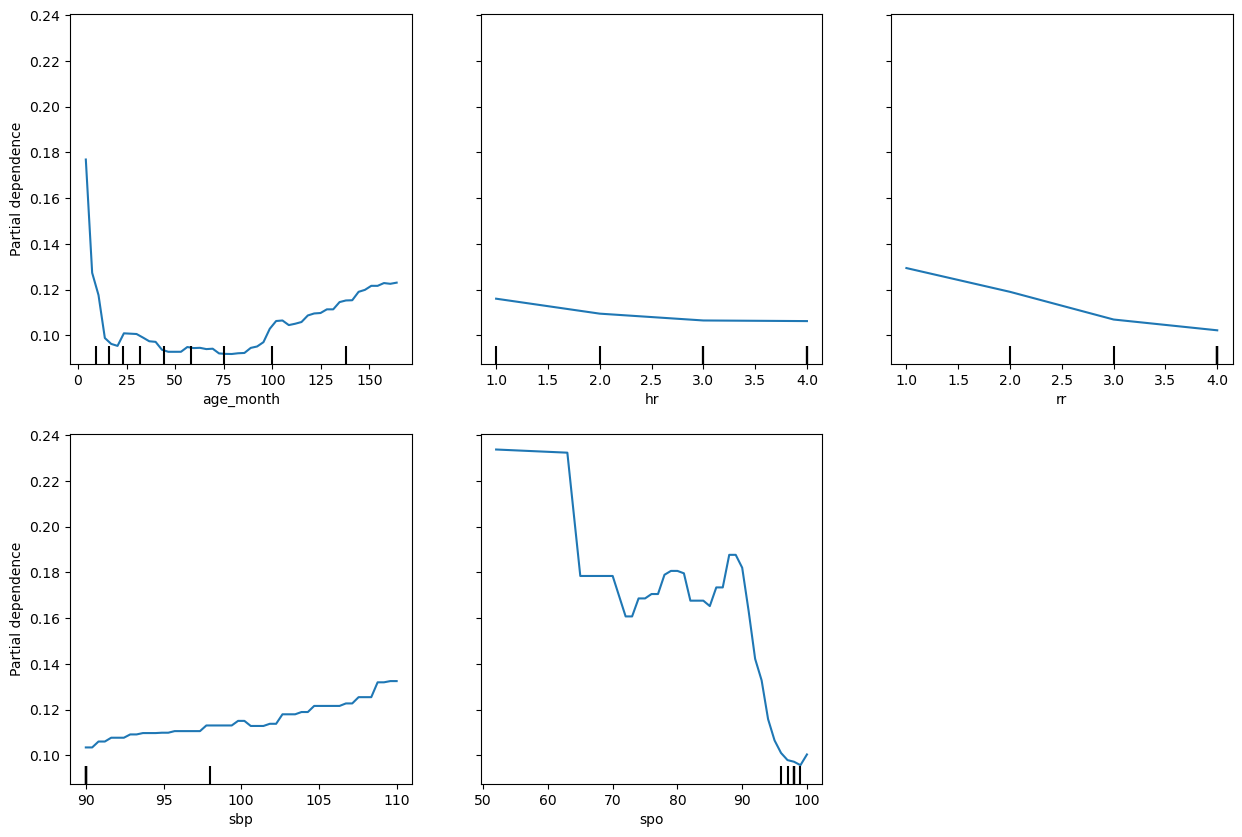

In [178]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 連続変数を指定 (例として、age_month, hr, rr, sbp, spo)
continuous_features = ['age_month', 'hr', 'rr', 'sbp', 'spo']  # 連続変数の例

# プロットサイズを設定（横長で大きめの図）
fig, ax = plt.subplots(figsize=(15, 10))  # figsizeを大きくして調整

# PDPのプロット (連続変数)
PartialDependenceDisplay.from_estimator(
    model_with_vs, X_test_with_vs, continuous_features, grid_resolution=50, ax=ax
)

# プロットを表示
plt.show()


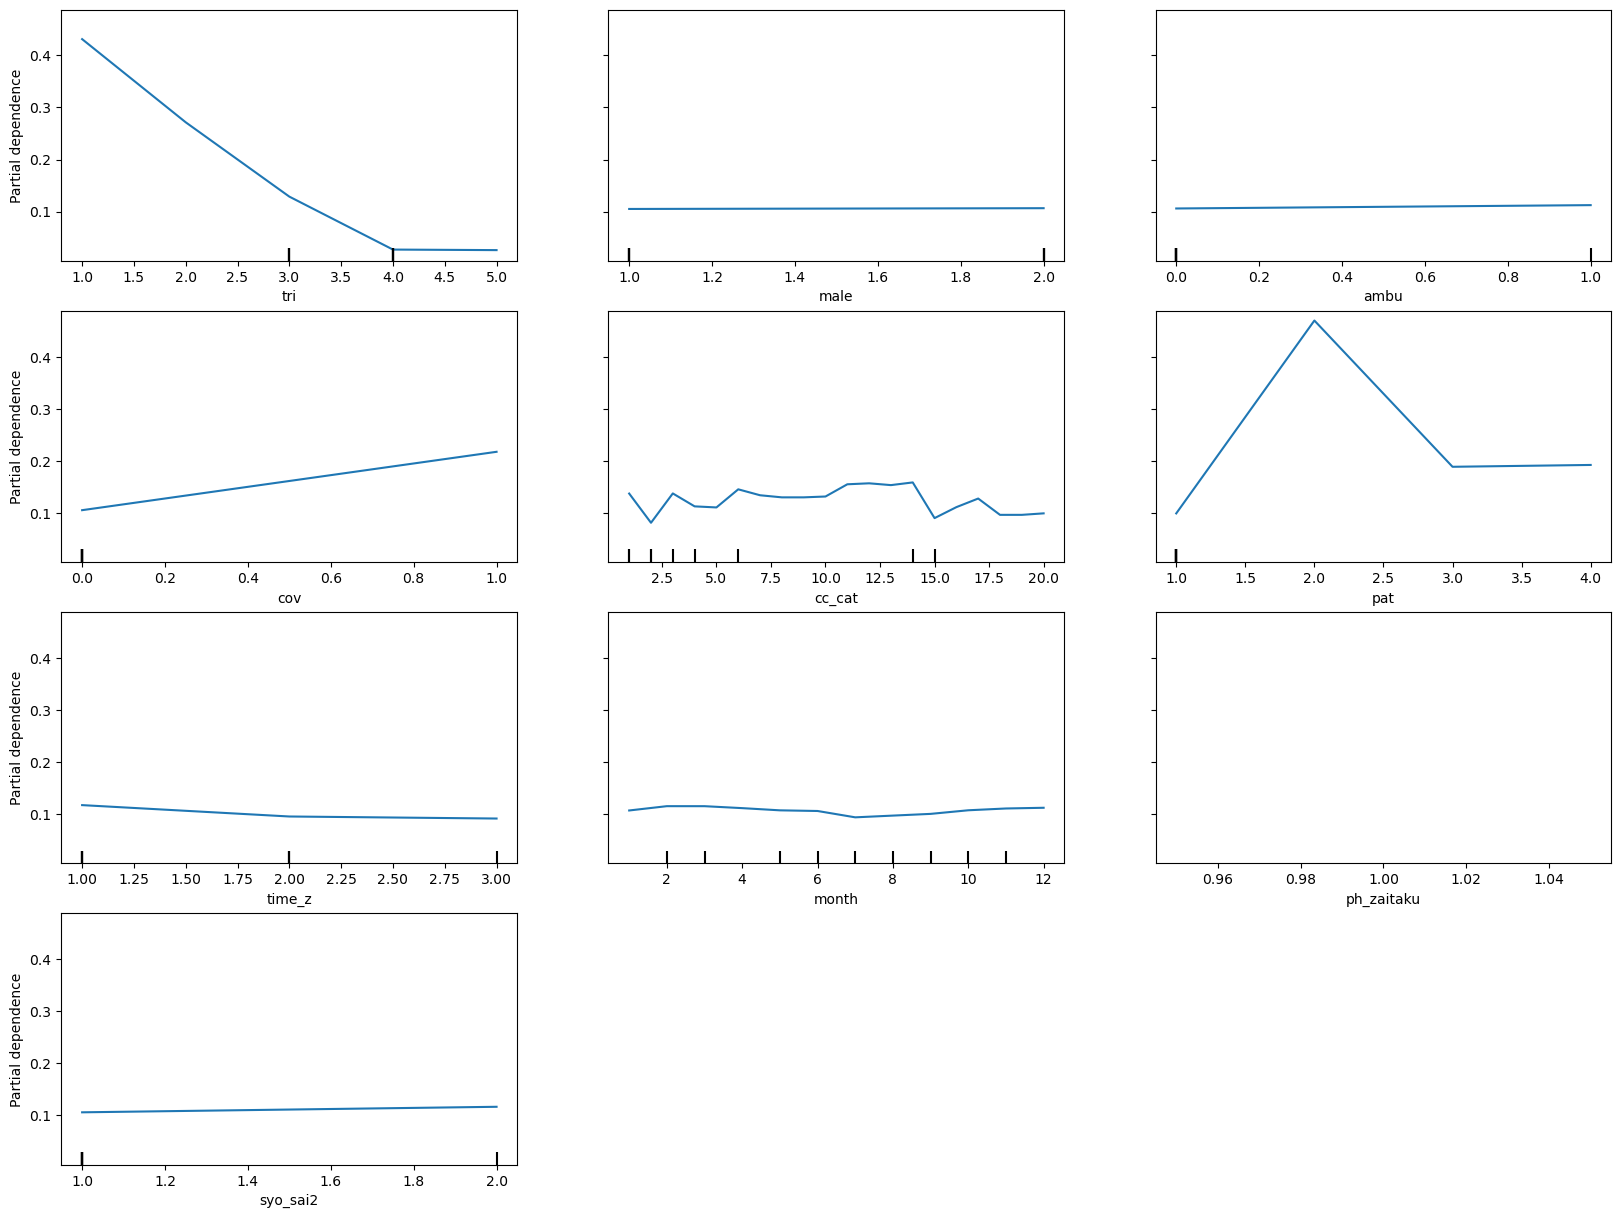

In [182]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# カテゴリー変数を指定 (例: tri, male)
categorical_features = ['tri', 'male', 'ambu', 'cov', 'cc_cat', 'pat', 'time_z', 'month', 'ph_zaitaku', 'syo_sai2']  # カテゴリー変数の例

# プロットサイズを設定（大きな図にまとめる）
fig, ax = plt.subplots(figsize=(20, 15))

# PDPのプロット (カテゴリー変数)
PartialDependenceDisplay.from_estimator(
    model_with_vs, X_test_with_vs, categorical_features, grid_resolution=50, ax=ax
)

# プロットを表示
plt.show()


In [15]:
###バイタルサインを含めたモデルで行う####
import pandas as pd
import numpy as np

data = pd.read_excel('/Users/ryujisasaki/anaconda3/jps2025_catb/tri_honban_analysis_final_data.xlsx')
# 前処理: 指定された変数を除外します
excluded_columns = [ 'bd', 'dx', 'id', 'picu', 'transf','or', 'fX', 'fY', 'iConf', 'iLvl']
data_cat = data.drop(columns=excluded_columns)

# バイタルサインの列を指定
vital_signs = ['hr', 'rr', 'bt', 'sbp', 'crt', 'spo']  # 例: バイタルサインの列

# モデル用の特徴量 (バイタルサインとトリアージレベル、その他の因子を含む)
tri = 'tri'
other_variables = [ 'year',  'month',  'wd',  'time_z', 'male', 'age_month', 'cov', 'ambu',
                  'syo_sai2', 'ref', 'hot', 'pat', 'ph_ba', 'ph_chd', 'ph_chromo',
       'ph_zaitaku', 'ph_epi', 'ph_transp_neop', 'cc_cat' ]  # 他の予測因子の例
# バイタルサインを含めた特徴量データセット
X_with_vs = data_cat[vital_signs + [tri] + other_variables]

# ターゲット変数
y = data_cat['adm']  # 入院予測ターゲット



from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
from catboost import CatBoostClassifier

# K-foldの設定
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# AUCとF1スコアのリスト
auc_scores = []
f1_scores = []

# K-fold cross-validation のループ
for train_index, test_index in kf.split(X_with_vs):
    X_train, X_test = X_with_vs.iloc[train_index], X_with_vs.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # CatBoostモデルの訓練
    model_with_vs = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0)
    model_with_vs.fit(X_train, y_train)
    
    # 予測
    y_pred = model_with_vs.predict(X_test)
    y_pred_proba = model_with_vs.predict_proba(X_test)[:, 1]
    
    # AUCとF1スコアを計算
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    
    auc_scores.append(auc)
    f1_scores.append(f1)

# 平均AUCとF1スコアを表示
print(f'Mean AUC: {np.mean(auc_scores)}')
print(f'Mean F1: {np.mean(f1_scores)}')


Mean AUC: 0.8873901255439813
Mean F1: 0.42860481254824795


In [17]:
# admの全体の数と入院（adm=1）の数をカウント
total_count = len(data_cat)
adm_count = data_cat['adm'].sum()

# 入院の割合を計算
adm_percentage = (adm_count / total_count) * 100

# 結果を表示
print(f"Total cases: {total_count}")
print(f"Admissions (adm=1): {adm_count}")
print(f"Admission rate: {adm_percentage:.2f}%")


Total cases: 133326
Admissions (adm=1): 14002
Admission rate: 10.50%


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# AUCとF1スコアは既に計算済みなので、他の指標を追加
accuracy_scores = []
specificity_scores = []
sensitivity_scores = []
precision_scores = []

# K-fold cross-validation のループで追加の指標を計算
for train_index, test_index in kf.split(X_with_vs):
    X_train, X_test = X_with_vs.iloc[train_index], X_with_vs.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # モデル訓練
    model_with_vs = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0)
    model_with_vs.fit(X_train, y_train)
    
    # 予測
    y_pred = model_with_vs.predict(X_test)
    
    # Accuracy（精度）
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    
    # Precision（適合率）
    precision_scores.append(precision_score(y_test, y_pred))
    
    # Sensitivity（再現率、感度）
    sensitivity_scores.append(recall_score(y_test, y_pred))
    
    # Specificity（特異度）は混同行列から計算
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    specificity_scores.append(specificity)

# 各指標の平均値を表示
print(f'Mean Accuracy: {np.mean(accuracy_scores)}')
print(f'Mean Precision: {np.mean(precision_scores)}')
print(f'Mean Sensitivity (Recall): {np.mean(sensitivity_scores)}')
print(f'Mean Specificity: {np.mean(specificity_scores)}')


Mean Accuracy: 0.9137527460312891
Mean Precision: 0.7044957666067087
Mean Sensitivity (Recall): 0.30800543586139145
Mean Specificity: 0.9848385230409334


In [23]:
from sklearn.metrics import confusion_matrix

# テストデータでの予測
y_pred = model_with_vs.predict(X_test)

# 混同行列の作成
cm = confusion_matrix(y_test, y_pred)

# 混同行列の結果を表示 (True Negative, False Positive, False Negative, True Positive)
tn, fp, fn, tp = cm.ravel()

# 各種率の計算
accuracy = (tp + tn) / (tp + tn + fp + fn)  # 全体の正解率
precision = tp / (tp + fp)  # 適合率
recall = tp / (tp + fn)  # 再現率（感度）
specificity = tn / (tn + fp)  # 特異度
fpr = fp / (fp + tn)  # 偽陽性率
fnr = fn / (fn + tp)  # 偽陰性率

# 結果の表示
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Positive Predictive Value): {precision:.2f}")
print(f"Recall (Sensitivity, True Positive Rate): {recall:.2f}")
print(f"Specificity (True Negative Rate): {specificity:.2f}")
print(f"False Positive Rate (FPR): {fpr:.2f}")
print(f"False Negative Rate (FNR): {fnr:.2f}")



Accuracy: 0.91
Precision (Positive Predictive Value): 0.70
Recall (Sensitivity, True Positive Rate): 0.31
Specificity (True Negative Rate): 0.99
False Positive Rate (FPR): 0.01
False Negative Rate (FNR): 0.69


In [29]:
from sklearn.metrics import precision_recall_curve, auc

# モデルの予測確率
y_pred_proba = model_with_vs.predict_proba(X_test_with_vs)[:, 1]

# Precision-Recall Curveの計算
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# AUC-PRCの計算
auc_prc = auc(recall, precision)

print(f"AUC-PRC: {auc_prc:.2f}")

# PRCのプロット
import matplotlib.pyplot as plt
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


NameError: name 'X_test_with_vs' is not defined